# Run Best Models and Evaluate Results

In [1]:
import pandas as pd
import numpy as np

### Load features

Change the filepath to a location on your local machine

In [2]:
df_features_census = pd.read_csv('../data/census_processed.csv', dtype={'geo_12': 'str'})
df_features_census["geo_12"] = df_features_census["GEO_ID"].map(lambda x: str(x)[-12:])
df_features_census.drop(["GEO_ID"], axis=1, inplace=True)

Change the filepath to a location on your local machine

In [3]:
df_features_places = pd.read_csv('../data/places_count_by_census_block.csv', dtype={'geo_12': 'str'})

In [4]:
df_features = df_features_places.merge(df_features_census, on='geo_12')

## Targets - diff data Feb-March/April 2020
### Load targets

In [5]:
df_targets_diff = pd.read_csv('../data/COVID_mobility_targets_adjusted.csv', dtype={'geo_12': 'str'})

### Create dataframe

In [6]:
df_diff = df_features.merge(df_targets_diff, on='geo_12')
df_diff.head()

,geo_12,automotive_repair_and_maintenance,child_day_care_services,elementary_and_secondary_schools,grocery_stores,health_and_personal_care_stores,"museums,_historical_sites,_and_similar_institutions",offices_of_physicians,other_amusement_and_recreation_industries,religious_organizations,...,Percent_Received_SNAP,Percent_Men_Usually_Fulltime_Employed,Percent_Women_Usually_Fulltime_Employed,Percent_No_Internet_Access,Percent_Computing_Device,Week,fraction_of_devices_home_adj,fraction_of_devices_work_adj,avg_time_away_all_adj,avg_time_away_leave_adj
0,170310101001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.18696,0.885906,0.382653,0.217742,0.782258,13,-0.086209,0.032714,-3.271241,-6.105604
1,170310101001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.18696,0.885906,0.382653,0.217742,0.782258,13,-0.090202,-0.035234,-2.828382,-5.560152
2,170310101001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.18696,0.885906,0.382653,0.217742,0.782258,13,-0.151460,0.077526,-2.280366,-5.380484
3,170310101001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.18696,0.885906,0.382653,0.217742,0.782258,14,-0.252164,0.048961,0.766927,-1.502261
4,170310101001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.18696,0.885906,0.382653,0.217742,0.782258,14,-0.256158,-0.018986,1.209787,-0.956809


### Split into training and testing

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_diff, test_size=0.2)
train.is_copy = None
test.is_copy = None

### Impute missing

In [8]:
train['Median_Income'].fillna((train['Median_Income'].median()), inplace=True)
test['Median_Income'].fillna((train['Median_Income'].median()), inplace=True)

/Users/amandawhaley/anaconda3/envs/ML_CAPP/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [9]:
train.dropna(inplace=True)
test.dropna(inplace=True)

/Users/amandawhaley/anaconda3/envs/ML_CAPP/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/amandawhaley/anaconda3/envs/ML_CAPP/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Random Forest Model

In [10]:
from sklearn.ensemble import RandomForestRegressor

### Features

In [11]:
features_cols = list(df_features.columns)
features_cols.remove('geo_12')

features_train = train[features_cols]
features_test = test[features_cols]

fodh_target_train, fodh_target_test = train['fraction_of_devices_home_adj'], test['fraction_of_devices_home_adj']
fodw_target_train, fodw_target_test = train['fraction_of_devices_work_adj'], test['fraction_of_devices_work_adj']

ataa_target_train, ataa_target_test = train['avg_time_away_all_adj'], test['avg_time_away_all_adj']
atal_target_train, atal_target_test = train['avg_time_away_leave_adj'], test['avg_time_away_leave_adj']

## Target: Reduction in Fraction of Devices at Home

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

rf_fodh = RandomForestRegressor(n_jobs=-1, 
                           n_estimators=205,
                           min_samples_split=7,
                           min_samples_leaf=2,
                           bootstrap=True
                            )
model_fodh = rf_fodh.fit(features_train,fodh_target_train)

#### Root Mean Squared Error

In [13]:
fodh_y_pred=rf_fodh.predict(features_test)
print("RMSE: ", np.sqrt(mean_squared_error(fodh_y_pred, fodh_target_test)))

RMSE:  0.05371836405695204


#### One to one plot

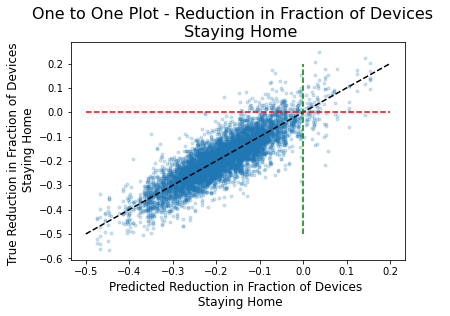

In [32]:
from matplotlib import pyplot as plt
plt.plot(fodh_y_pred, fodh_target_test, '.', alpha = 0.2)
plt.ylabel('True Reduction in Fraction of Devices \n Staying Home', fontsize=12)
plt.xlabel('Predicted Reduction in Fraction of Devices \n Staying Home', fontsize=12)
plt.title('One to One Plot - Reduction in Fraction of Devices  \n Staying Home', fontsize=16)
line_x, line_y = [-0.5,0.2], [-0.5,0.2]
line_cutoff = [0,0]
plt.plot(line_x,line_y,'k--')
plt.plot(line_x,line_cutoff,'r--')
plt.plot(line_cutoff, line_y, 'g--')
plt.show()

#### We should discuss the policy implications of this!!!

#### Residual Plot

Text(0, 0.5, 'Model Residual (Predicted - True)')

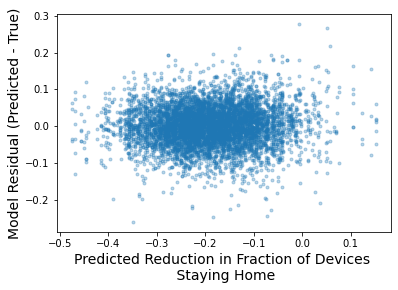

In [15]:
residuals_fodh = fodh_y_pred - fodh_target_test
plt.plot(fodh_y_pred, residuals_fodh, '.', alpha=0.3)
plt.xlabel('Predicted Reduction in Fraction of Devices \n Staying Home', fontsize=14)
plt.ylabel('Model Residual (Predicted - True)', fontsize=14)

/Users/amandawhaley/anaconda3/envs/ML_CAPP/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/amandawhaley/anaconda3/envs/ML_CAPP/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


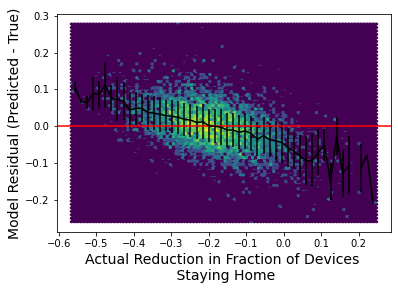

In [16]:
x = fodh_target_test
y = residuals_fodh

n, _ = np.histogram(x, bins=50)
sy, _ = np.histogram(x, bins=50, weights=y)
sy2, _ = np.histogram(x, bins=50, weights=y*y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)


plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='k-')
plt.hexbin(x, y, bins='log')
plt.axhline(y=0, color='r')
plt.xlabel('Actual Reduction in Fraction of Devices \n Staying Home', fontsize=14)
plt.ylabel('Model Residual (Predicted - True)', fontsize=14)
plt.show()

## Target: Fraction of Devices with Work Behavior

In [17]:
rf_fodw = RandomForestRegressor(n_jobs=-1, 
                                   n_estimators=400,
                                   min_samples_split=7,
                                   min_samples_leaf=2,
                                   max_depth=120,
                                   bootstrap=True
                            )
model_fodw = rf_fodw.fit(features_train,fodw_target_train)

#### Root Mean Squared Error

In [18]:
fodw_y_pred=rf_fodw.predict(features_test)
print("RMSE: ", np.sqrt(mean_squared_error(fodw_y_pred, fodw_target_test)))

RMSE:  0.030962403814217495


#### One to one plot

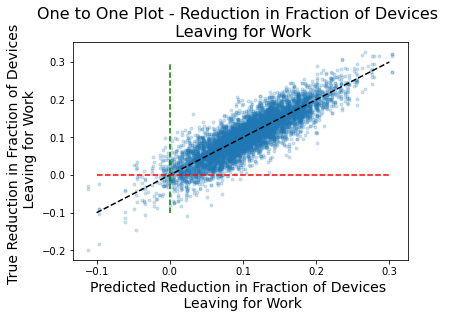

In [33]:
plt.plot(fodw_y_pred, fodw_target_test, '.', alpha = 0.2)
plt.ylabel('True Reduction in Fraction of Devices \n Leaving for Work', fontsize=14)
plt.xlabel('Predicted Reduction in Fraction of Devices \n Leaving for Work', fontsize=14)
plt.title('One to One Plot - Reduction in Fraction of Devices \n Leaving for Work', fontsize=16)
line_x, line_y = [-0.1,0.3], [-0.1,0.3]
line_cutoff = [0,0]
plt.plot(line_x,line_y,'k--')
plt.plot(line_x,line_cutoff,'r--')
plt.plot(line_cutoff, line_y, 'g--')
plt.show()

#### Residual Plot

Text(0, 0.5, 'Model Residual (Predicted - True)')

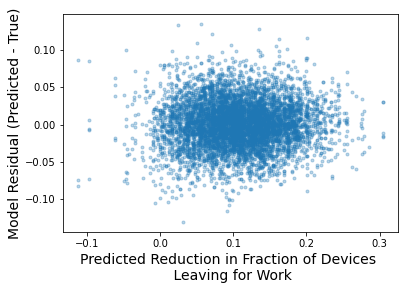

In [20]:
residuals_fodw = fodw_y_pred - fodw_target_test
plt.plot(fodw_y_pred, residuals_fodw, '.', alpha=0.3)
plt.xlabel('Predicted Reduction in Fraction of Devices \n Leaving for Work', fontsize=14)
plt.ylabel('Model Residual (Predicted - True)', fontsize=14)

/Users/amandawhaley/anaconda3/envs/ML_CAPP/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/amandawhaley/anaconda3/envs/ML_CAPP/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


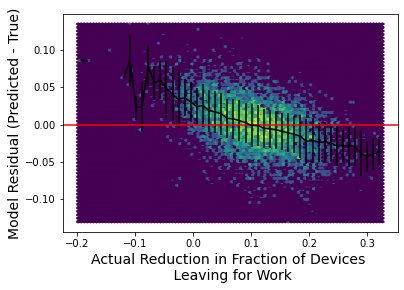

In [21]:
x = fodw_target_test
y = residuals_fodw

n, _ = np.histogram(x, bins=50)
sy, _ = np.histogram(x, bins=50, weights=y)
sy2, _ = np.histogram(x, bins=50, weights=y*y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)


plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='k-')
plt.hexbin(x, y, bins='log')
plt.axhline(y=0, color='r')
plt.xlabel('Actual Reduction in Fraction of Devices \n Leaving for Work', fontsize=14)
plt.ylabel('Model Residual (Predicted - True)', fontsize=14)
plt.show()

## Target: Average Time Away From Home (All)

In [22]:
rf_ataa = RandomForestRegressor(n_jobs=-1, 
                                    n_estimators=120,
                                    min_samples_split=4,
                                    min_samples_leaf=2,
                                    bootstrap=True
                            )
model_ataa = rf_ataa.fit(features_train,ataa_target_train)

#### Root Mean Squared Error

In [23]:
ataa_y_pred=rf_ataa.predict(features_test)
print("RMSE: ", np.sqrt(mean_squared_error(ataa_y_pred, ataa_target_test)))

RMSE:  0.7301207471651563


#### One to one plot

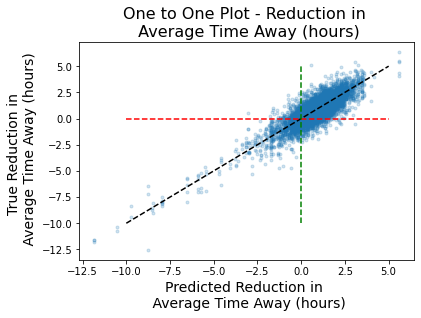

In [34]:
plt.plot(ataa_y_pred, ataa_target_test, '.', alpha = 0.2)
plt.ylabel('True Reduction in \n Average Time Away (hours)', fontsize=14)
plt.xlabel('Predicted Reduction in \n Average Time Away (hours)', fontsize=14)
plt.title('One to One Plot - Reduction in \n Average Time Away (hours)', fontsize=16)
line_x, line_y = [-10,5], [-10,5]
line_cutoff = [0,0]
plt.plot(line_x,line_y,'k--')
plt.plot(line_x,line_cutoff,'r--')
plt.plot(line_cutoff, line_y, 'g--')
plt.show()

#### Residual Plot

Text(0, 0.5, 'Model Residual (Predicted - True)')

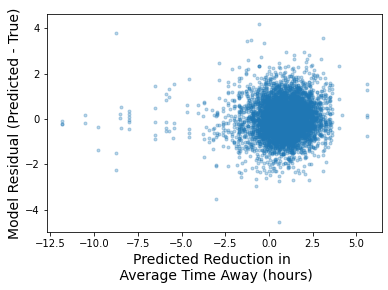

In [25]:
residuals_ataa = ataa_y_pred - ataa_target_test
plt.plot(ataa_y_pred, residuals_ataa, '.', alpha=0.3)
plt.xlabel('Predicted Reduction in \n Average Time Away (hours)', fontsize=14)
plt.ylabel('Model Residual (Predicted - True)', fontsize=14)

/Users/amandawhaley/anaconda3/envs/ML_CAPP/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/amandawhaley/anaconda3/envs/ML_CAPP/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


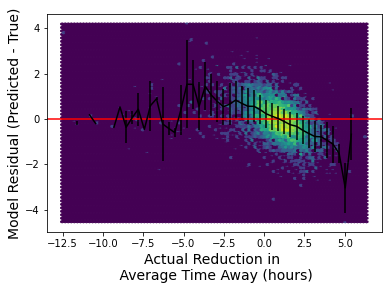

In [26]:
x = ataa_target_test
y = residuals_ataa

n, _ = np.histogram(x, bins=50)
sy, _ = np.histogram(x, bins=50, weights=y)
sy2, _ = np.histogram(x, bins=50, weights=y*y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)


plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='k-')
plt.hexbin(x, y, bins='log')
plt.axhline(y=0, color='r')
plt.xlabel('Actual Reduction in \n Average Time Away (hours)', fontsize=14)
plt.ylabel('Model Residual (Predicted - True)', fontsize=14)
plt.show()

## Target: Average Time Away From Home (Leavers)

In [27]:
rf_atal = RandomForestRegressor(n_jobs=-1, 
                                    n_estimators=350,
                                    min_samples_leaf=2,
                                    max_depth=140,
                                    bootstrap=True
                            )
model_atal = rf_atal.fit(features_train,atal_target_train)

#### Root Mean Squared Error

In [28]:
atal_y_pred=rf_atal.predict(features_test)
print("RMSE: ", np.sqrt(mean_squared_error(atal_y_pred, atal_target_test)))

RMSE:  1.0762709196110538


#### One to one plot

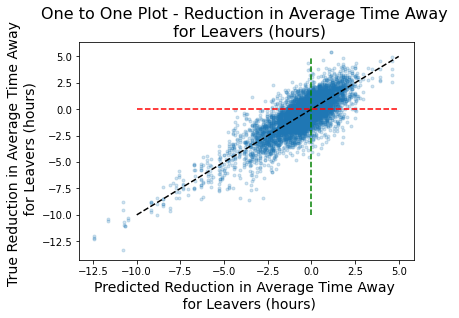

In [35]:
plt.plot(atal_y_pred, atal_target_test, '.', alpha = 0.2)
plt.ylabel('True Reduction in Average Time Away \n for Leavers (hours)', fontsize=14)
plt.xlabel('Predicted Reduction in Average Time Away \n for Leavers (hours)', fontsize=14)
plt.title('One to One Plot - Reduction in Average Time Away \n for Leavers (hours)', fontsize=16)
line_x, line_y = [-10,5], [-10,5]
line_cutoff = [0,0]
plt.plot(line_x,line_y,'k--')
plt.plot(line_x,line_cutoff,'r--')
plt.plot(line_cutoff, line_y, 'g--')
plt.show()

#### Residual Plot

Text(0, 0.5, 'Model Residual (Predicted - True)')

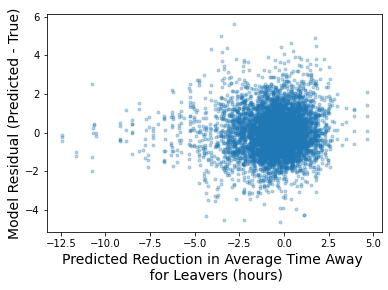

In [30]:
residuals_atal = atal_y_pred - atal_target_test
plt.plot(atal_y_pred, residuals_atal, '.', alpha=0.3)
plt.xlabel('Predicted Reduction in Average Time Away \n for Leavers (hours)', fontsize=14)
plt.ylabel('Model Residual (Predicted - True)', fontsize=14)

/Users/amandawhaley/anaconda3/envs/ML_CAPP/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/amandawhaley/anaconda3/envs/ML_CAPP/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


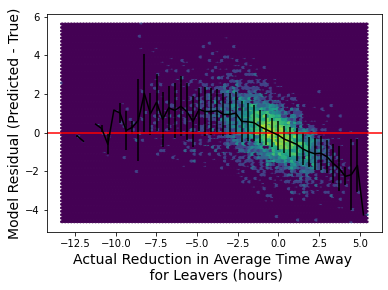

In [31]:
x = atal_target_test
y = residuals_atal

n, _ = np.histogram(x, bins=50)
sy, _ = np.histogram(x, bins=50, weights=y)
sy2, _ = np.histogram(x, bins=50, weights=y*y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)


plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='k-')
plt.hexbin(x, y, bins='log')
plt.axhline(y=0, color='r')
plt.xlabel('Actual Reduction in Average Time Away \n for Leavers (hours)', fontsize=14)
plt.ylabel('Model Residual (Predicted - True)', fontsize=14)
plt.show()